# **Importing libraries**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# **Dataset Preprocessing and splitting**

In [ ]:
# Transform data from PIL image to tensors so that pytorch can process
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) #True will load training otherwise test if it false
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



trainset, validateset = random_split(train_data, [45000, 5000])

batchSize = 200

train_loader = DataLoader(trainset, batch_size=batchSize, shuffle=True) #Dataloader is a pytorchclass use to iterate over dataset
validate_loader = DataLoader(validateset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)


print(f'Training Samples: {len(trainset)}')
print(f'Validation Samples: {len(validateset)}')
print(f'Test Samples: {len(test_data)}')

# Classes in CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified
Training Samples: 45000
Validation Samples: 5000
Test Samples: 10000


# **Visulaization of some zoomin images from dataset**

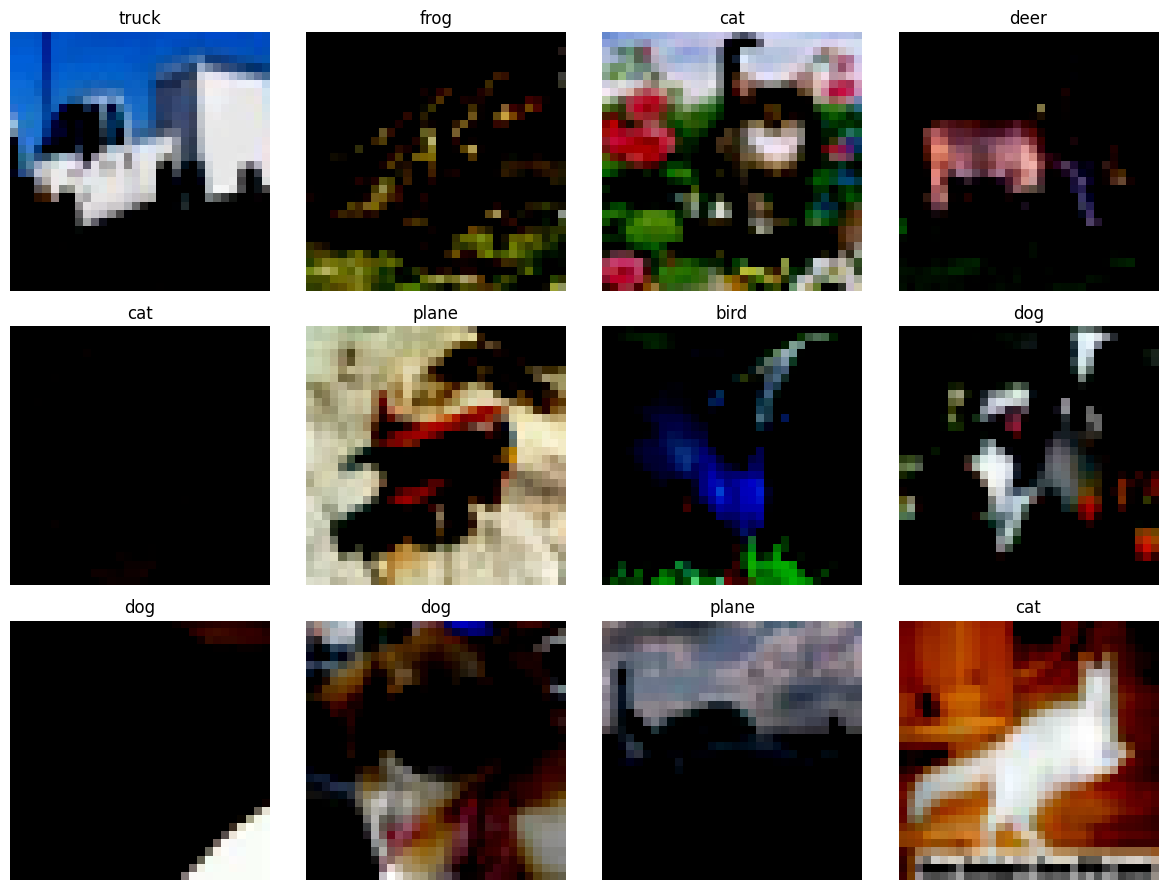

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i in range(12):
    img, label = validateset[i]  # Load image and label


    if img.max() > 1:  # Check if the image values are likely in the [0, 255] range
        img = img / 255.0  # Normalize the image to [0, 1]

    # Clip the image to the [0, 1] range to avoid warnings
    img = img.clamp(0, 1)

    axes[i].imshow(img.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for imshow
    axes[i].set_title(classes[label])  # Set the title of the subplot as class name
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# **CNN Model Arcitect**

In [ ]:
class Cifar10Classifier(nn.Module):
    def __init__(self): #Current Instance
        super().__init__()

        self.network = nn.Sequential( #Container use to define neural network layers


            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),


            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),


            nn.Flatten(), #to convert 2D into 1D
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch):
        images, labels = batch

        # call the model itself
        out = self(images)

        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)

# **Evaluation of model**

In [ ]:

@torch.no_grad() #disable gradient descent
def evaluateModel(model, validationLoader):

    model.eval()
    out = [model.validationStep(batch) for batch in validationLoader]

    return model.validationEpochEnd(out)


# **TrainingLoop**

In [ ]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    optimizer = optimizationFunction(model.parameters(), lr)

    for epoch in range(epochs):
        print(f"training epoch {epoch}")

        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainingLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"{evaluateModel(model, validationLoader)}")

In [ ]:
# instantiate the model
model = Cifar10Classifier()
#evaluateModel(model, validate_loader)
trainModel(6, 0.001, model, trainLoader=train_loader, validationLoader=validate_loader, optimizationFunction=torch.optim.Adam)


training epoch 0
{'loss': 1.5021923780441284, 'accuracy': 0.45259997248649597}
training epoch 1
{'loss': 1.1544480323791504, 'accuracy': 0.5796000361442566}
training epoch 2
{'loss': 0.9027156233787537, 'accuracy': 0.6798000335693359}
training epoch 3
{'loss': 0.7609650492668152, 'accuracy': 0.737000048160553}
training epoch 4
{'loss': 0.7170347571372986, 'accuracy': 0.7526000142097473}
training epoch 5
{'loss': 0.6757974028587341, 'accuracy': 0.7712000012397766}


# **Check Results on Validation and Test Datasets**

In [ ]:
print(f"validation dataset accuracy: {evaluateModel(model, validate_loader)}")
print(f"test dataset accuracy: {evaluateModel(model, test_loader)}")

validation dataset accuracy: {'loss': 0.6757973432540894, 'accuracy': 0.7712000012397766}
test dataset accuracy: {'loss': 0.6978081464767456, 'accuracy': 0.7660999894142151}


# **Model Predictions On Testdataset**

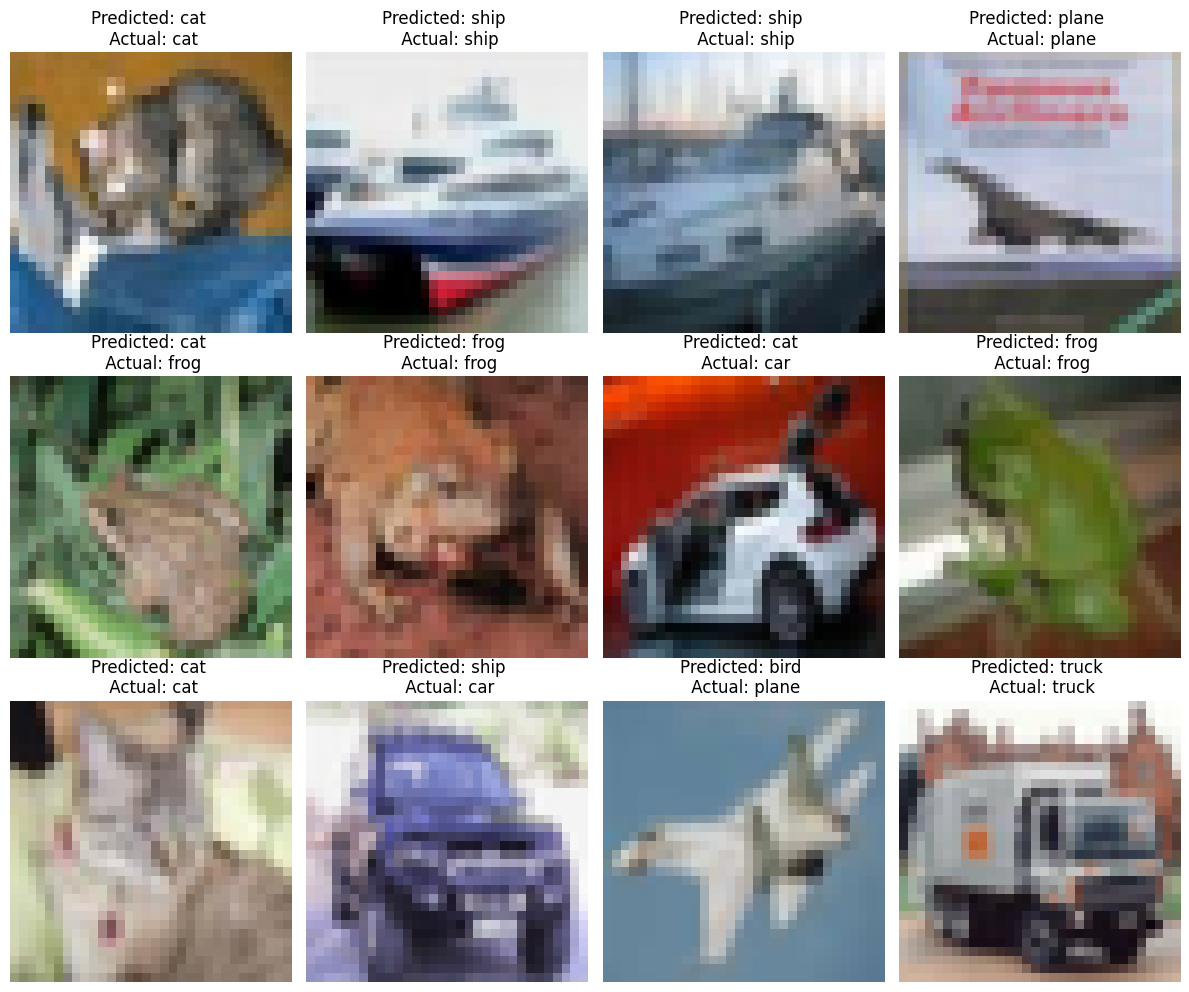

In [ ]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

import torch

# Define the unnormalize function
def unnormalize(img):
    """
    Unnormalize the image tensor from the range [-1, 1] to [0, 1].
    """
    return img * 0.5 + 0.5

with torch.no_grad():
    fig, axs = plt.subplots(3, 4, figsize=(12, 10))

    for i in range(12):
        img, label = test_data[i]

        # Unnormalize the image
        img = unnormalize(img)

        # Predict the label
        predictedValue = predictImage(img, model)

        # Get subplot row and column
        row, col = divmod(i, 4)
        axs[row, col].imshow(img.permute(1, 2, 0))  # Display the image
        axs[row, col].set_title(f"Predicted: {classes[predictedValue]} \n Actual: {classes[label]}")
        axs[row, col].axis('off')

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()


# **Confusion Matrix**

<Axes: >

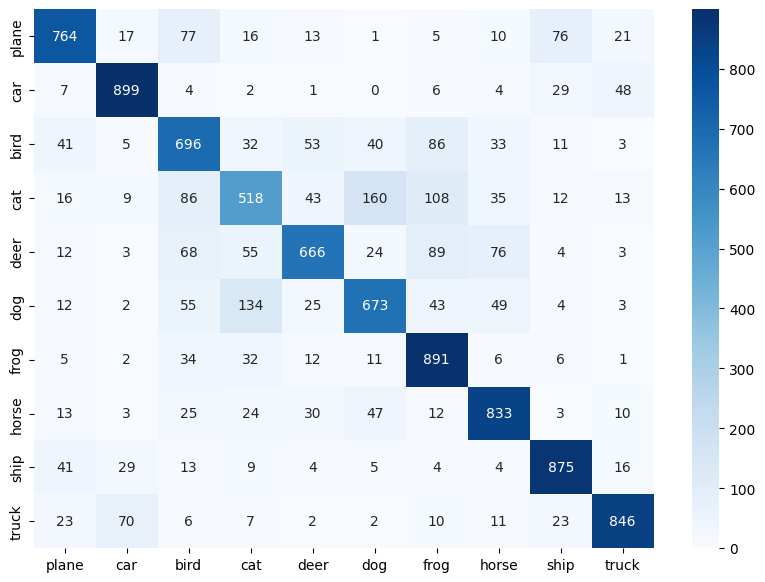

In [ ]:
predictions = np.empty((0, len(test_data)), np.int32)
actualValues = np.empty((0, len(test_data)), np.int32)

with torch.no_grad():
    for i in range(0, len(test_data)):
        testImg, testLabel = test_data[i]
        predictedValue = predictImage(testImg, model)

        predictions = np.append(predictions, predictedValue)
        actualValues = np.append(actualValues, testLabel)
confusionMatrix = confusion_matrix(actualValues, predictions)

confusionMatrixDf = pd.DataFrame(confusionMatrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(confusionMatrixDf, annot=True, cmap='Blues', fmt='g')
